# 03 - XGBoost Experiment
This notebook benchmarks an XGBoost classifier against the current LightGBM baseline used in the project.

## 1. Data Ingestion and Feature Engineering
Load the curated training data, detect feature types, and assemble the preprocessing pipeline (imputation, scaling, and encoding).

In [1]:
import os
import sys
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)
from sklearn.pipeline import Pipeline
import joblib
import xgboost as xgb

sys.path.append(os.path.abspath(".."))
from src.data import load_raw_data, TARGET_COL
from src.features import infer_feature_types, make_preprocessor
from src.models import get_model

train_df, _, _ = load_raw_data()
train_df = train_df.drop_duplicates().reset_index(drop=True)
num_cols, cat_cols = infer_feature_types(train_df, TARGET_COL)
preprocessor = make_preprocessor(num_cols, cat_cols)
X = train_df.drop(columns=[TARGET_COL])
y = train_df[TARGET_COL]
print(f"Numeric features: {len(num_cols)} | Categorical features: {len(cat_cols)}")

Numeric features: 6 | Categorical features: 6


## 2. Train/Test Split and $k$-Fold Setup
Create reproducible training and validation splits plus a stratified $k$-fold utility for downstream cross-validation.

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
N_SPLITS = 5

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
print(f"Train shape: {X_train.shape} | Validation shape: {X_val.shape}")

Train shape: (475195, 12) | Validation shape: (118799, 12)


## 3. Baseline Metrics with Existing Model
Re-train the established LightGBM baseline to anchor metrics (accuracy, precision, recall, and ROC-AUC).

In [3]:
baseline_model = get_model("lgbm")
baseline_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", baseline_model)
])
baseline_pipeline.fit(X_train, y_train)

baseline_preds = baseline_pipeline.predict(X_val)
baseline_proba = baseline_pipeline.predict_proba(X_val)[:, 1]

baseline_metrics = {
    "accuracy": accuracy_score(y_val, baseline_preds),
    "precision": precision_score(y_val, baseline_preds, zero_division=0),
    "recall": recall_score(y_val, baseline_preds, zero_division=0),
    "roc_auc": roc_auc_score(y_val, baseline_proba)
}
print(json.dumps(baseline_metrics, indent=2))

[LightGBM] [Info] Number of positive: 379595, number of negative: 95600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1639
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798819 -> initscore=1.378932
[LightGBM] [Info] Start training from score 1.378932
{
  "accuracy": 0.9049318596957887,
  "precision": 0.9078412051084422,
  "recall": 0.9805266651914141,
  "roc_auc": 0.9206846609570951
}
{
  "accuracy": 0.9049318596957887,
  "precision": 0.9078412051084422,
  "recall": 0.9805266651914141,
  "roc_auc": 0.9206846609570951
}


## 4. Configure and Train XGBoost Classifier
Instantiate `xgboost.XGBClassifier`, pick the appropriate tree method (GPU if available), and measure base training time.

In [4]:
try:
    from xgboost.core import _has_cuda_support
    tree_method = "gpu_hist" if _has_cuda_support() else "hist"
except Exception:
    tree_method = "hist"

xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method=tree_method,
    random_state=RANDOM_STATE,
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1
)

xgb_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", xgb_clf)
])

start_time = time.time()
xgb_pipeline.fit(X_train, y_train)
base_train_time = time.time() - start_time
print(f"Tree method: {tree_method} | Base training time: {base_train_time:.2f}s")

c:\vs-code-projects\Loan\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Tree method: hist | Base training time: 29.90s


## 5. Hyperparameter Search for XGBoost
Explore a focused hyperparameter space via `RandomizedSearchCV` to extract the best-performing configuration.

In [5]:
param_distributions = {
    "model__n_estimators": [300, 500, 700, 900],
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "model__max_depth": [4, 6, 8, 10],
    "model__subsample": [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "model__gamma": [0, 0.5, 1.0],
    "model__min_child_weight": [1, 3, 5]
}

search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=12,
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    refit=True
)
search_start = time.time()
search.fit(X_train, y_train)
search_time = time.time() - search_start
best_xgb_pipeline = search.best_estimator_
print(f"Search time: {search_time/60:.1f} min")
print(json.dumps(search.best_params_, indent=2))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\vs-code-projects\Loan\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Search time: 35.3 min
{
  "model__subsample": 0.9,
  "model__n_estimators": 700,
  "model__min_child_weight": 1,
  "model__max_depth": 4,
  "model__learning_rate": 0.1,
  "model__gamma": 1.0,
  "model__colsample_bytree": 0.7
}


## 6. Model Evaluation and Diagnostics
Compare tuned XGBoost predictions against the baseline using rich metrics, confusion matrices, and ROC/PR curves.

Baseline: {
  "label": "LightGBM Baseline",
  "accuracy": 0.9049318596957887,
  "precision": 0.9078412051084422,
  "recall": 0.9805266651914141,
  "roc_auc": 0.9206846609570951
}
Tuned XGBoost: {
  "label": "Tuned XGBoost",
  "accuracy": 0.9046709147383395,
  "precision": 0.9082356389214536,
  "recall": 0.9796415136092056,
  "roc_auc": 0.9208482548347702
}

Classification report (XGBoost):
               precision    recall  f1-score   support

         0.0       0.88      0.61      0.72     23900
         1.0       0.91      0.98      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.90      0.79      0.83    118799
weighted avg       0.90      0.90      0.90    118799


Classification report (XGBoost):
               precision    recall  f1-score   support

         0.0       0.88      0.61      0.72     23900
         1.0       0.91      0.98      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.90   

C:\Users\marka\AppData\Local\Temp\ipykernel_20320\1526055080.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


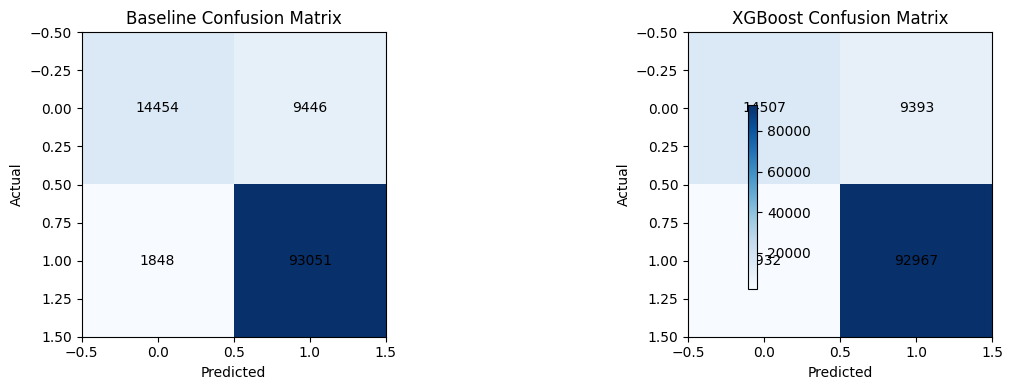

NameError: name 'auc' is not defined

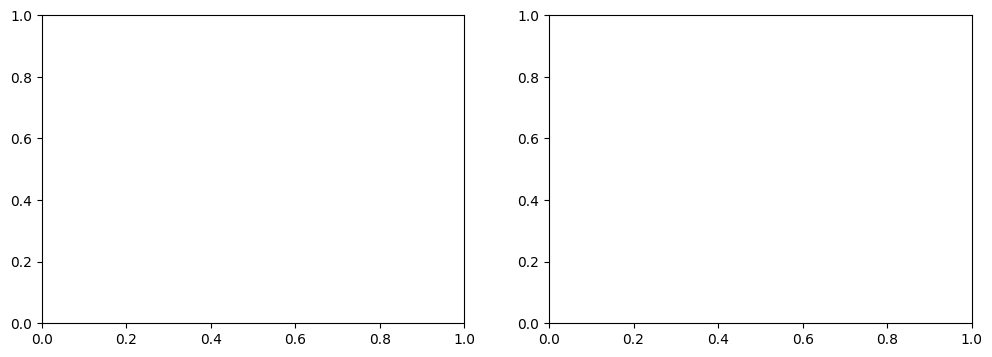

In [6]:
def evaluate_model(estimator, X_eval, y_eval, label):
    preds = estimator.predict(X_eval)
    probas = estimator.predict_proba(X_eval)[:, 1]
    metrics = {
        "label": label,
        "accuracy": accuracy_score(y_eval, preds),
        "precision": precision_score(y_eval, preds, zero_division=0),
        "recall": recall_score(y_eval, preds, zero_division=0),
        "roc_auc": roc_auc_score(y_eval, probas)
    }
    return metrics, preds, probas

baseline_eval, baseline_preds, baseline_proba = evaluate_model(
    baseline_pipeline, X_val, y_val, label="LightGBM Baseline"
)
xgb_eval, xgb_preds, xgb_proba = evaluate_model(
    best_xgb_pipeline, X_val, y_val, label="Tuned XGBoost"
)

print("Baseline:", json.dumps(baseline_eval, indent=2))
print("Tuned XGBoost:", json.dumps(xgb_eval, indent=2))
print("\nClassification report (XGBoost):\n", classification_report(y_val, xgb_preds, zero_division=0))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, preds, title in zip(
    axes,
    [baseline_preds, xgb_preds],
    ["Baseline Confusion Matrix", "XGBoost Confusion Matrix"]
):
    cm = confusion_matrix(y_val, preds)
    im = ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    for (i, j), value in np.ndenumerate(cm):
        ax.text(j, i, int(value), ha="center", va="center", color="black")
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fpr_base, tpr_base, _ = roc_curve(y_val, baseline_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, xgb_proba)
axes[0].plot(fpr_base, tpr_base, label=f"Baseline AUC={auc(fpr_base, tpr_base):.3f}")
axes[0].plot(fpr_xgb, tpr_xgb, label=f"XGB AUC={auc(fpr_xgb, tpr_xgb):.3f}")
axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[0].set_title("ROC Curves")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].legend()

prec_base, rec_base, _ = precision_recall_curve(y_val, baseline_proba)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_val, xgb_proba)
axes[1].plot(rec_base, prec_base, label="Baseline")
axes[1].plot(rec_xgb, prec_xgb, label="XGBoost")
axes[1].set_title("Precision-Recall Curves")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend()
plt.tight_layout()
plt.show()

## 7. Feature Importance and SHAP Analysis
Explain top predictors with gain-based importances and SHAP values to highlight the strongest drivers of approval.

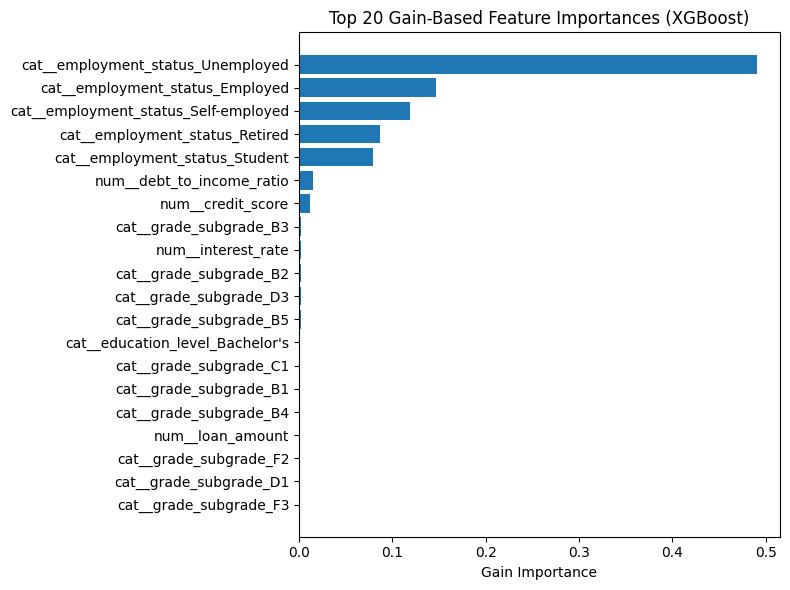

Install `shap` to view model explanations.


In [7]:
best_preprocessor = best_xgb_pipeline.named_steps["preprocess"]
best_model = best_xgb_pipeline.named_steps["model"]
feature_names = list(best_preprocessor.get_feature_names_out())

importance_df = (
    pd.DataFrame({"feature": feature_names, "importance": best_model.feature_importances_})
    .sort_values("importance", ascending=False)
    .head(20)
)
plt.figure(figsize=(8, 6))
plt.barh(importance_df["feature"], importance_df["importance"])
plt.gca().invert_yaxis()
plt.title("Top 20 Gain-Based Feature Importances (XGBoost)")
plt.xlabel("Gain Importance")
plt.tight_layout()
plt.show()

try:
    import shap

    shap.initjs()
    X_val_processed = best_preprocessor.transform(X_val)
    if hasattr(X_val_processed, "toarray"):
        X_val_processed = X_val_processed.toarray()
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_val_processed)
    shap.summary_plot(shap_values, X_val_processed, feature_names=feature_names, max_display=20)
except ImportError:
    print("Install `shap` to view model explanations.")

## 8. Persist Trained Model and Metrics
Save the tuned XGBoost pipeline plus evaluation metadata for downstream batch scoring and monitoring.

In [8]:
artifacts_dir = Path("artifacts/xgb")
artifacts_dir.mkdir(parents=True, exist_ok=True)
model_path = artifacts_dir / "xgb_best_pipeline.joblib"
metrics_path = artifacts_dir / "xgb_metrics.json"

joblib.dump(best_xgb_pipeline, model_path)
with metrics_path.open("w", encoding="utf-8") as fp:
    json.dump(
        {
            "baseline": baseline_eval,
            "xgboost": xgb_eval,
            "search_time_min": round(search_time / 60, 2),
            "train_time_s": round(base_train_time, 2)
        },
        fp,
        indent=2
    )

print(f"Saved tuned pipeline to {model_path}")
print(f"Saved metrics to {metrics_path}")

Saved tuned pipeline to artifacts\xgb\xgb_best_pipeline.joblib
Saved metrics to artifacts\xgb\xgb_metrics.json
